**Script Description:** This script loads the complete merged dataset, perform outlier detection, compute pearson correlation coreffient and simple linear regression on the the SMC variables.

**File Name:** 02_00_RQ1_Statistical_Analysis.ipynb

**Date:** 2025

**Created by:** Rob Alamgir  

##### Import the relevant packages

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.dates as mdates
from matplotlib.patches import Patch

### Step 1: Load and pre-process the dataset

In [2]:
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data_Final/Pre_Processed_Data_All_Locations_V6.csv"  
complete_dataset = pd.read_csv(data_path, low_memory=False)
complete_dataset['Date'] = pd.to_datetime(complete_dataset['Date'])
#complete_dataset.info(verbose=True)

filtered_df = complete_dataset[["Date", "Site_ID", "SENTEK_SMC", "Planet_SMC", "Sentinel_1_SMC"]].copy()
filtered_df = filtered_df.dropna()

filtered_df_V1 = filtered_df.dropna(subset=["SENTEK_SMC", "Planet_SMC", "Sentinel_1_SMC"])
valid_sites = filtered_df_V1["Site_ID"].value_counts().index  
filtered_df_V1 = filtered_df_V1[filtered_df_V1["Site_ID"].isin(valid_sites)]
melted_df = filtered_df_V1.melt(id_vars=["Date", "Site_ID"], 
                             value_vars=["SENTEK_SMC", "Planet_SMC", "Sentinel_1_SMC"], 
                             var_name="Soil Moisture Variable", 
                             value_name="Value")

#### Plot Box plot of all three SMC variables 

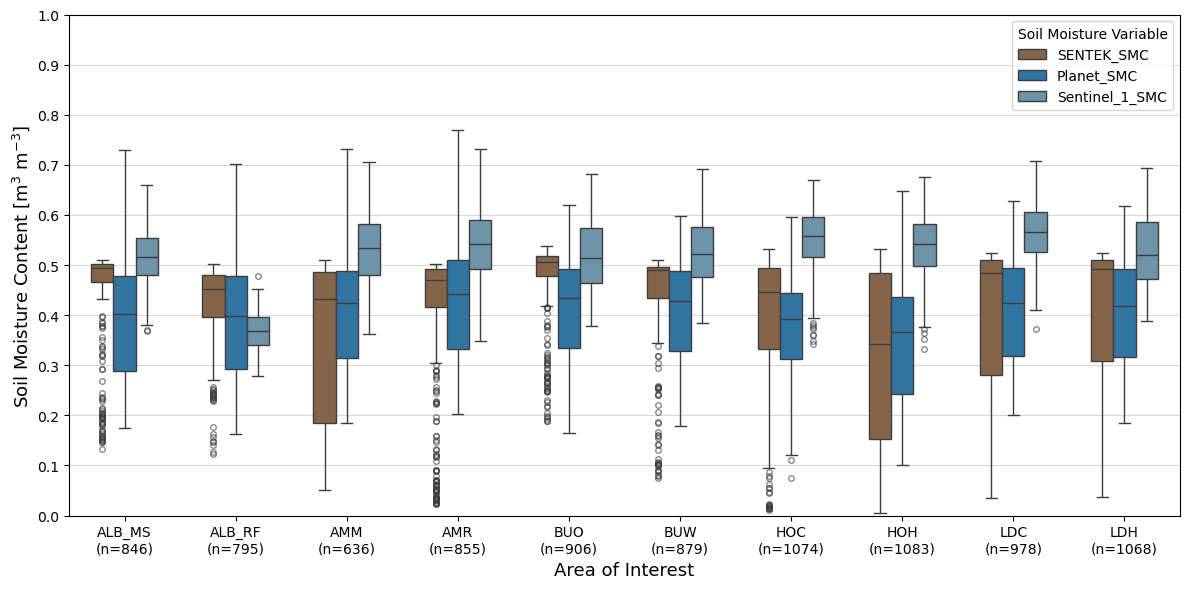

In [4]:
sorted_sites = sorted(melted_df["Site_ID"].unique())                      # Sort Site_IDs alphabetically
obs_counts = melted_df.groupby("Site_ID", observed=True)["Value"].count() # Calculate number of observations per site
new_labels = [f"{site}\n(n={obs_counts[site]})" for site in sorted_sites] # Create new labels with counts

custom_palette = {"SENTEK_SMC": "#8D663F",  
                  "Planet_SMC": "#1f77b4",  
                  "Sentinel_1_SMC": "#6497b1"}

flierprops = dict(marker='o', markersize=4, linestyle='none', alpha=0.6)
plt.figure(figsize=(12, 6))  
sns.boxplot(data=melted_df, x="Site_ID", y="Value", 
            hue="Soil Moisture Variable", palette=custom_palette, 
            width=0.6, dodge=True, flierprops=flierprops)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))  
plt.xlabel("Area of Interest", size=13)
plt.ylabel("Soil Moisture Content [m$^{3}$ m$^{-3}$]", size=13)
#plt.title("Distribution of Soil Moisture CO Variables Across Locations", size=14)
plt.legend(title="Soil Moisture Variable", bbox_to_anchor=(1, 1))
plt.xticks(ticks=range(len(sorted_sites)), labels=new_labels, rotation=0)
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Box_plot_AOI.png"  
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

### Step 2: Detect Outliers 

In [ ]:
# While Z-score can be useful for normally distributed data, it's more susceptible to the influence of outliers. 
#def detect_z_score_outliers(df, var_name, threshold=3):
#    """Detects outliers using the Z-score method."""
#    z_scores = np.abs(stats.zscore(df[var_name]))
#    outlier_indices = np.where(z_scores > threshold)[0]
#    return outlier_indices

#outlier_indices_planet = detect_z_score_outliers(filtered_df, 'Planet_SWC')
#outlier_indices_s1 = detect_z_score_outliers(filtered_df, 'S1_VSM')
#outlier_indices_swct = detect_z_score_outliers(filtered_df, 'SWCT_1_015')

#print("\nZ-Score Outlier Indices:")
#print("Planet_SWC:", outlier_indices_planet)
#print("S1_VSM:", outlier_indices_s1)
#print("SWCT_1_015:", outlier_indices_swct)

In [5]:
def detect_iqr_outliers(df, var_name):
    """Detects outliers using the IQR method."""

    Q1 = df[var_name].quantile(0.25)
    Q3 = df[var_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = df.loc[(df[var_name] < lower_bound) | (df[var_name] > upper_bound)].index.to_numpy()
    return outlier_indices

outlier_indices_planet_iqr = detect_iqr_outliers(filtered_df, 'Planet_SMC')
outlier_indices_s1_iqr = detect_iqr_outliers(filtered_df, 'Sentinel_1_SMC')
outlier_indices_swct_iqr = detect_iqr_outliers(filtered_df, 'SENTEK_SMC')

#print("\nIQR Outlier Indices:")
#print("Planet_SWC:", outlier_indices_planet_iqr)
#print("S1_VSM:", outlier_indices_s1_iqr)
#print("SWCT_1_015:", outlier_indices_swct_iqr)

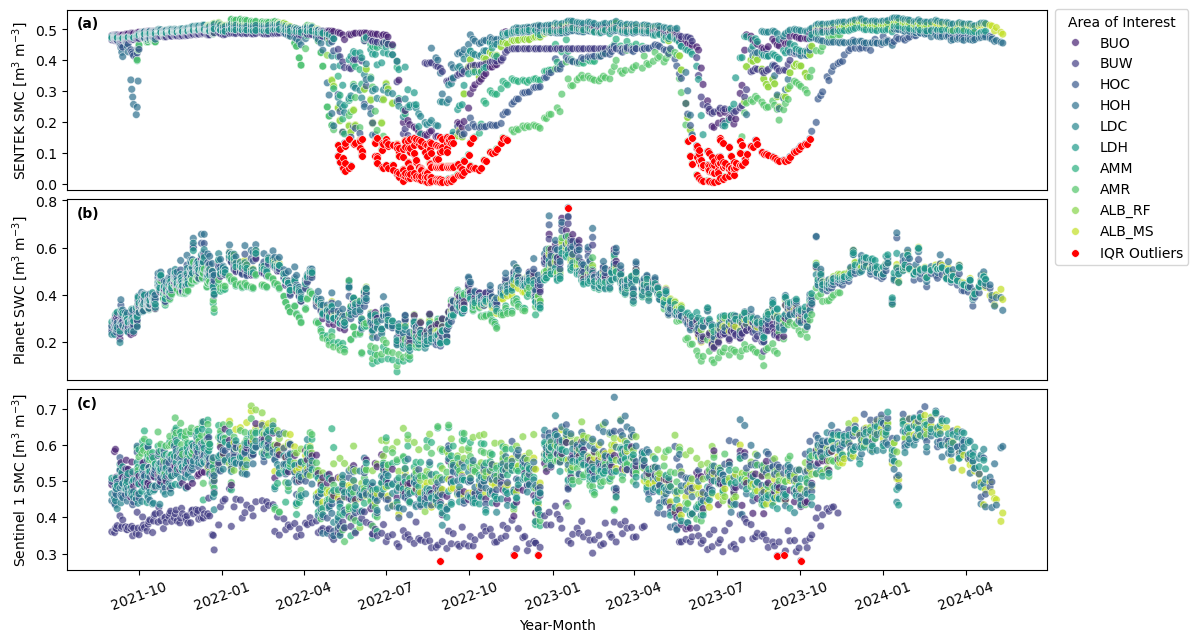

In [6]:
# Subset data and outliers for each variable
outliers_planet = filtered_df.loc[outlier_indices_planet_iqr]
outliers_swct = filtered_df.loc[outlier_indices_swct_iqr]
outliers_s1 = filtered_df.loc[outlier_indices_s1_iqr]

# Create subplot figure
fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(3, hspace=0.05)
axs = gs.subplots(sharex=True)
# First subplot: SWCT_1_015
sns.scatterplot(ax=axs[0], data=filtered_df, x="Date", y="SENTEK_SMC", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
sns.scatterplot(ax=axs[0], data=outliers_swct, x="Date", y="SENTEK_SMC", color="red", label="IQR Outliers", s=30)
axs[0].set_ylabel("SENTEK SMC [m$^{3}$ m$^{-3}$]")
axs[0].get_legend().remove()
axs[0].text(0.01, 0.9, "(a)", transform=axs[0].transAxes, fontsize=10, fontweight="bold")
# Second subplot: Planet_SWC
sns.scatterplot(ax=axs[1], data=filtered_df, x="Date", y="Planet_SMC", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
sns.scatterplot(ax=axs[1], data=outliers_planet, x="Date", y="Planet_SMC", color="red", label="IQR Outliers", s=30)
axs[1].set_ylabel("Planet SWC [m$^{3}$ m$^{-3}$]")
axs[1].legend(title="Area of Interest", bbox_to_anchor=(1.001, 2.09), loc='upper left')
axs[1].text(0.01, 0.9, "(b)", transform=axs[1].transAxes, fontsize=10, fontweight="bold")
# Third subplot: S1_VSM
sns.scatterplot(ax=axs[2], data=filtered_df, x="Date", y="Sentinel_1_SMC", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
sns.scatterplot(ax=axs[2], data=outliers_s1, x="Date", y="Sentinel_1_SMC", color="red", label="IQR Outliers", s=30)
axs[2].set_xlabel("Year-Month")
axs[2].set_ylabel("Sentinel 1 SMC [m$^{3}$ m$^{-3}$]")
axs[2].get_legend().remove()
axs[2].text(0.01, 0.9, "(c)", transform=axs[2].transAxes, fontsize=10, fontweight="bold")
axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

for ax in axs[:-1]:
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
axs[2].tick_params(axis='x', rotation=20)
plt.subplots_adjust(left=0.1, right=0.8, top=0.95, bottom=0.15)
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/TS_AOI_IQR_Outliers.png"  
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

### Step 3: Compute Descriptive Statistics 

In [7]:
# Function to calculate descriptive statistics
def calculate_descriptive_stats(df, var_name):
    """Calculates descriptive statistics for a given variable."""
    stats_df = pd.DataFrame({
        'mean': [df[var_name].mean()],
        'median': [df[var_name].median()],
        'std': [df[var_name].std()],
        'variance': [df[var_name].var()],
        'min': [df[var_name].min()],
        'max': [df[var_name].max()],
        '25%': [df[var_name].quantile(0.25)],
        '75%': [df[var_name].quantile(0.75)]
    })
    return stats_df

all_sites_descriptive_stats = {}
all_sites_summary_df = pd.DataFrame()

for var in ["SENTEK_SMC", "Planet_SMC", "Sentinel_1_SMC"]:
    stats = calculate_descriptive_stats(filtered_df, var)
    all_sites_descriptive_stats[var] = stats
    stats.insert(0, 'Variable', var)
    all_sites_summary_df = pd.concat([all_sites_summary_df, stats], ignore_index=True)

site_descriptive_stats = {}
site_summary_df = pd.DataFrame()

for site, site_data in filtered_df.groupby('Site_ID'):
    site_descriptive_stats[site] = {}
    for var in ["SENTEK_SMC", "Planet_SMC", "Sentinel_1_SMC"]:
        stats = calculate_descriptive_stats(site_data, var)
        site_descriptive_stats[site][var] = stats
        stats.insert(0, 'Site_ID', site)
        stats.insert(1, 'Variable', var)
        site_summary_df = pd.concat([site_summary_df, stats], ignore_index=True)

# Print the summary DataFramesprint("\nAll Sites Summary:\n", all_sites_summary_df)
#print("\nSite-wise Summary:\n", site_summary_df)

### Step 4: Pearson Correlation and Simple Regression Analysis 

In [8]:
from scipy import stats
site_results = {}
for site, site_data in filtered_df.groupby('Site_ID'):
    if len(site_data) >= 2:
        correlation_planet, p_value_planet_corr = stats.pearsonr(site_data['Planet_SMC'], site_data['SENTEK_SMC'])
        correlation_s1, p_value_s1_corr = stats.pearsonr(site_data['Sentinel_1_SMC'], site_data['SENTEK_SMC'])
        # Simple Linear Regression Analysis
        model_planet = smf.ols('SENTEK_SMC ~ Planet_SMC', data=site_data).fit()
        model_s1 = smf.ols('SENTEK_SMC ~ Sentinel_1_SMC', data=site_data).fit()
        site_results[site] = {
            'Planet_SMC Correlation': correlation_planet,
            'Planet_SMC p-value Correlation': p_value_planet_corr,
            'Planet_SMC R$^{2}$': model_planet.rsquared,
            'Planet_SMC RMSE': np.sqrt(mean_squared_error(site_data['SENTEK_SMC'], model_planet.predict(site_data['Planet_SMC']))),
            'Sentinel_1_SMC Correlation': correlation_s1,
            'Sentinel_1_SMC p-value Correlation': p_value_s1_corr,
            'Sentinel_1_SMC R$^{2}$': model_s1.rsquared,
            'Sentinel_1_SMC RMSE': np.sqrt(mean_squared_error(site_data['SENTEK_SMC'], model_s1.predict(site_data['Sentinel_1_SMC'])))
        }
    else:
        print(f"Skipping site {site} due to insufficient data points.")
        site_results[site] = "Insufficient data"
site_results_df = pd.DataFrame(site_results).T
print("\nSite-Specific Correlation and Regression Results:\n", site_results_df)


Site-Specific Correlation and Regression Results:
         Planet_SMC Correlation  Planet_SMC p-value Correlation  \
ALB_MS                0.834060                    2.674898e-74   
ALB_RF                0.832601                    1.937913e-69   
AMM                   0.453671                    3.694959e-12   
AMR                   0.613656                    7.035619e-31   
BUO                   0.499870                    1.700016e-20   
BUW                   0.572481                    6.547196e-27   
HOC                   0.642894                    3.912065e-43   
HOH                   0.665136                    1.835859e-47   
LDC                   0.697956                    6.615668e-49   
LDH                   0.669136                    1.442515e-47   

        Planet_SMC R$^{2}$  Planet_SMC RMSE  Sentinel_1_SMC Correlation  \
ALB_MS            0.695655         0.091225                    0.595193   
ALB_RF            0.693224         0.093484                    0.402283

### Plotting the PCC and SLR results

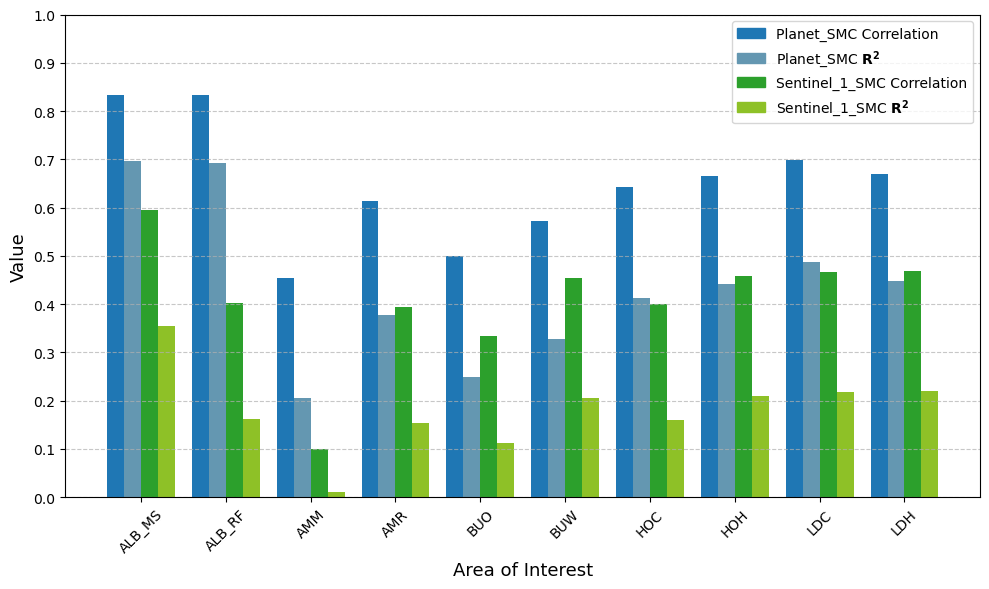

In [9]:
selected_columns = [
    'Planet_SMC Correlation',
    'Planet_SMC R$^{2}$',
    'Sentinel_1_SMC Correlation',
    'Sentinel_1_SMC R$^{2}$'
]

colors = ["#1f77b4", "#6497b1", "#2ca02c", "#8ec127"]
bar_width = 0.2
locations = np.arange(len(site_results_df))

plt.figure(figsize=(10, 6))

for i, column in enumerate(selected_columns):
    plt.bar(locations + i * bar_width, site_results_df[column], width=bar_width, color=colors[i])

plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.xlabel("Area of Interest", size=13)
plt.ylabel("Value", size=13)
#plt.title("Pearson Correlation and R² of RS Data vs SENTEK_SMC Across AOIs", size=13)
plt.xticks(locations + bar_width * 1.5, site_results_df.index, rotation=45)

# Custom legend with only "R²" bolded
legend_labels = [
    'Planet_SMC Correlation',
    r'Planet_SMC $\mathbf{R^2}$',
    'Sentinel_1_SMC Correlation',
    r'Sentinel_1_SMC $\mathbf{R^2}$'
]
legend_patches = [Patch(color=colors[i], label=legend_labels[i]) for i in range(len(colors))]
plt.legend(handles=legend_patches, title="")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RSD_GSD_PCC_R2_AOI.png"  
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

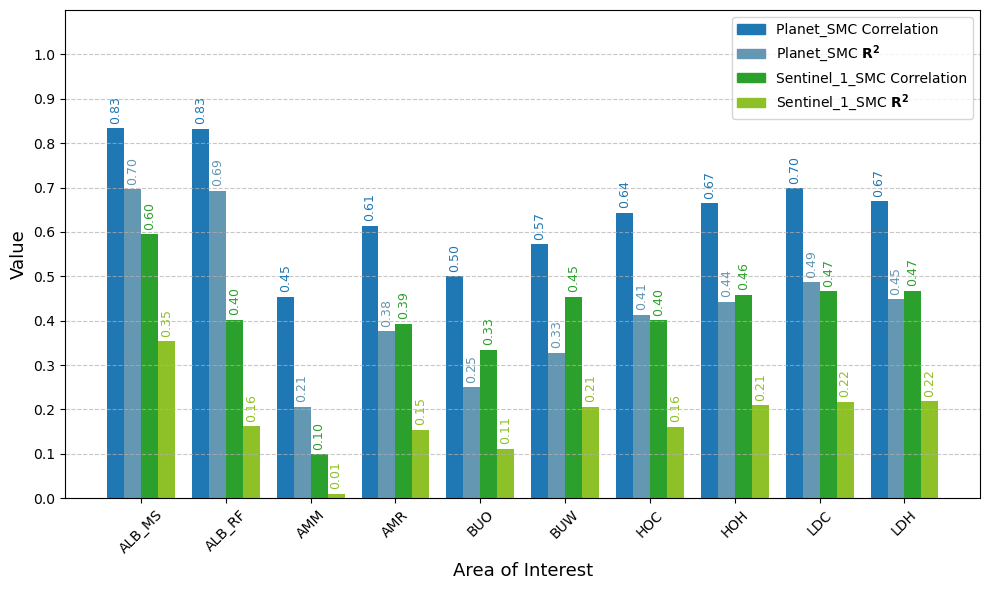

In [10]:
selected_columns = [
    'Planet_SMC Correlation',
    'Planet_SMC R$^{2}$',
    'Sentinel_1_SMC Correlation',
    'Sentinel_1_SMC R$^{2}$'
]

colors = ["#1f77b4", "#6497b1", "#2ca02c", "#8ec127"]
bar_width = 0.2
locations = np.arange(len(site_results_df))

plt.figure(figsize=(10, 6))

for i, column in enumerate(selected_columns):
    bar_positions = locations + i * bar_width
    bar_values = site_results_df[column]
    plt.bar(bar_positions, bar_values, width=bar_width, color=colors[i])
    # Add value labels (same color as bar + vertical)
    for x, y in zip(bar_positions, bar_values):
        plt.text(
            x, y + 0.01, f"{y:.2f}",
            ha='center', va='bottom',
            fontsize=9, rotation=90,
            color=colors[i]
        )

plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Area of Interest", size=13)
plt.ylabel("Value", size=13)
# plt.title("Pearson Correlation and R² of RS Data vs SENTEK_SMC Across AOIs", size=13)
plt.xticks(locations + bar_width * 1.5, site_results_df.index, rotation=45)

legend_labels = [
    'Planet_SMC Correlation',
    r'Planet_SMC $\mathbf{R^2}$',
    'Sentinel_1_SMC Correlation',
    r'Sentinel_1_SMC $\mathbf{R^2}$'
]
legend_patches = [Patch(color=colors[i], label=legend_labels[i]) for i in range(len(colors))]
plt.legend(handles=legend_patches, title="")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RSD_GSD_PCC_R2_AOI.png"
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

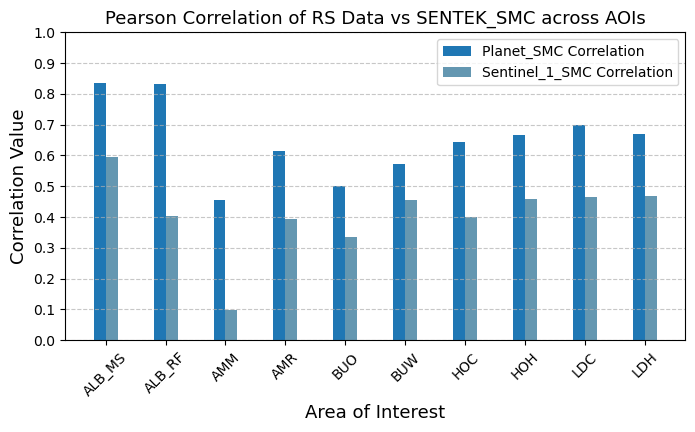

In [11]:
correlation_df = site_results_df[["Planet_SMC Correlation", "Sentinel_1_SMC Correlation"]]
colors = ["#1f77b4", "#6497b1"]
bar_width = 0.2
locations = np.arange(len(correlation_df))

plt.figure(figsize=(8, 4))

for i, column in enumerate(correlation_df.columns):
    plt.bar(locations + i * bar_width, correlation_df[column], width=bar_width, label=column, color=colors[i])

plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.xlabel("Area of Interest", size=13)
plt.ylabel("Correlation Value", size=13)
plt.title("Pearson Correlation of RS Data vs SENTEK_SMC across AOIs", size=13)
plt.xticks(locations + bar_width * 0.5, correlation_df.index, rotation=45)
plt.legend(title="")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/test.png"  
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")

#### TS plot of of SENTEK_SMC, Planet_SMC, Sentinel_1_SMC & Water Level

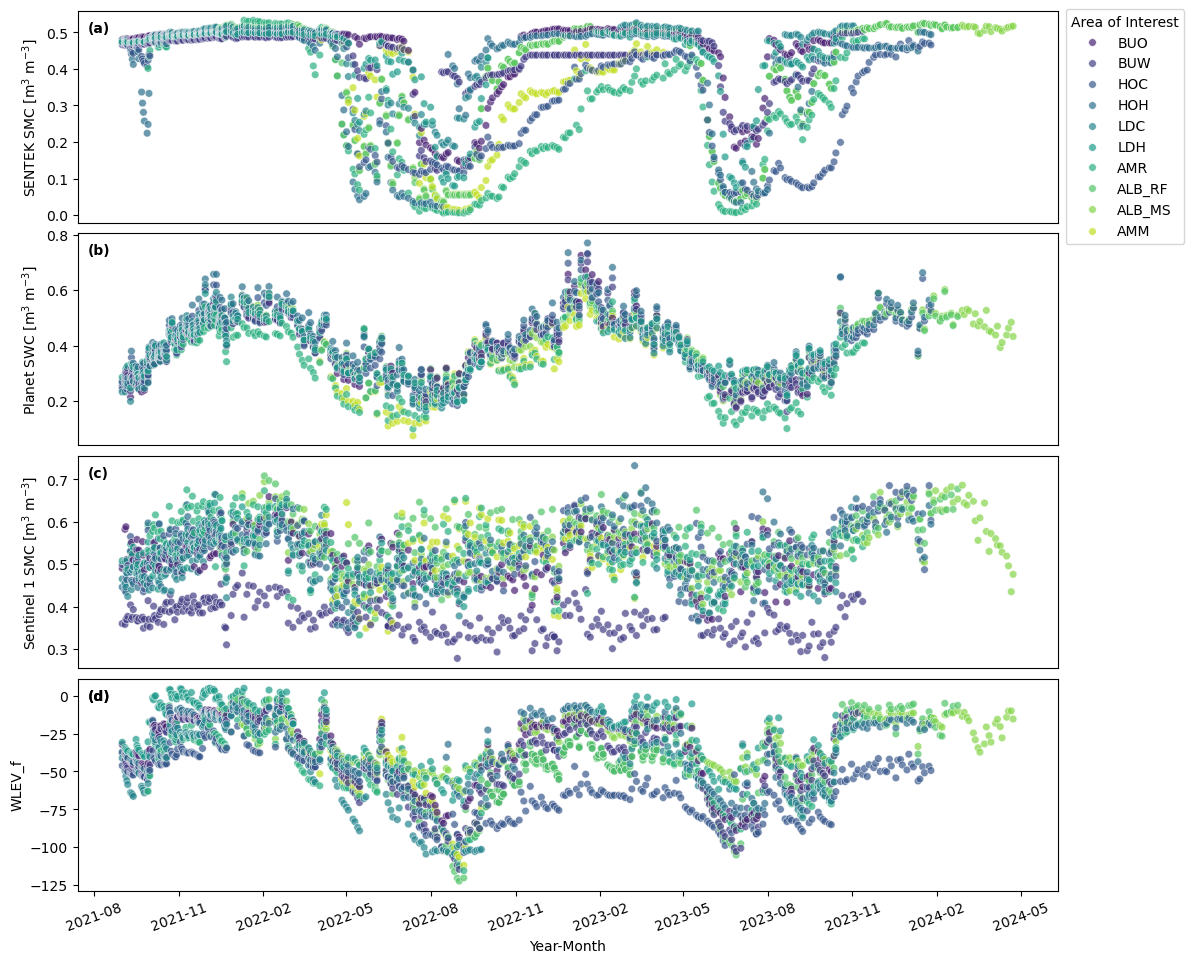

In [15]:
TS_plot_df = complete_dataset[["Date", "Site_ID", "year_month", "SENTEK_SMC", "Planet_SMC", "Sentinel_1_SMC", "WLEV_f"]].copy()
TS_plot_df = TS_plot_df.dropna(subset=["Date", "Site_ID", "year_month", "SENTEK_SMC", "Planet_SMC", "Sentinel_1_SMC", "WLEV_f"])
# Create a separate dataframe to compute monthly means
wlev_df = complete_dataset[["Date", "Site_ID", "WLEV_f", "year_month"]].copy()
wlev_df["Monthly_WLEV_f"] = wlev_df.groupby(["Site_ID", "year_month"])["WLEV_f"].transform("mean")

# Merge the monthly WLEV_f back into TS_plot_df
TS_plot_df = TS_plot_df.merge(wlev_df[["Date", "Site_ID", "Monthly_WLEV_f"]], on=["Date", "Site_ID"], how="left")

fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(4, hspace=0.05)
axs = gs.subplots(sharex=True)

# (a) SENTEK_SMC
plot_a = sns.scatterplot(ax=axs[0], data=TS_plot_df, x="Date", y="SENTEK_SMC", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
plot_a.legend_.remove()  # Remove legend
axs[0].set_ylabel("SENTEK SMC [m$^{3}$ m$^{-3}$]")
axs[0].text(0.01, 0.9, "(a)", transform=axs[0].transAxes, fontsize=10, fontweight="bold")
# (b) Planet_SMC 
plot_b = sns.scatterplot(ax=axs[1], data=TS_plot_df, x="Date", y="Planet_SMC", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
axs[1].set_ylabel("Planet SWC [m$^{3}$ m$^{-3}$]")
axs[1].legend(title="Area of Interest", bbox_to_anchor=(1.001, 2.09), loc='upper left')
axs[1].text(0.01, 0.9, "(b)", transform=axs[1].transAxes, fontsize=10, fontweight="bold")
# (c) Sentinel_1_SMC
plot_c = sns.scatterplot(ax=axs[2], data=TS_plot_df, x="Date", y="Sentinel_1_SMC", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
plot_c.legend_.remove()
axs[2].set_ylabel("Sentinel 1 SMC [m$^{3}$ m$^{-3}$]")
axs[2].text(0.01, 0.9, "(c)", transform=axs[2].transAxes, fontsize=10, fontweight="bold")
# (d) WLEV_f
plot_d = sns.scatterplot(ax=axs[3], data=TS_plot_df, x="Date", y="WLEV_f", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
plot_d.legend_.remove()
axs[3].set_xlabel("Year-Month")
axs[3].set_ylabel("WLEV_f")
axs[3].text(0.01, 0.9, "(d)", transform=axs[3].transAxes, fontsize=10, fontweight="bold")
axs[3].set_xlabel("Year-Month")
axs[3].set_ylabel("WLEV_f")
axs[3].text(0.01, 0.9, "(d)", transform=axs[3].transAxes, fontsize=10, fontweight="bold")
axs[3].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[3].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

for ax in axs[:-1]:
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
axs[3].tick_params(axis='x', rotation=20)

plt.subplots_adjust(left=0.1, right=0.8, top=0.95, bottom=0.15)
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/PCC_Matrix_RQ1.png"  
#ax.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

#### TS plot of SENTEK_SMC, Planet_SMC, Sentinel_1_SMC, Water Level, Monthly Precipitaion

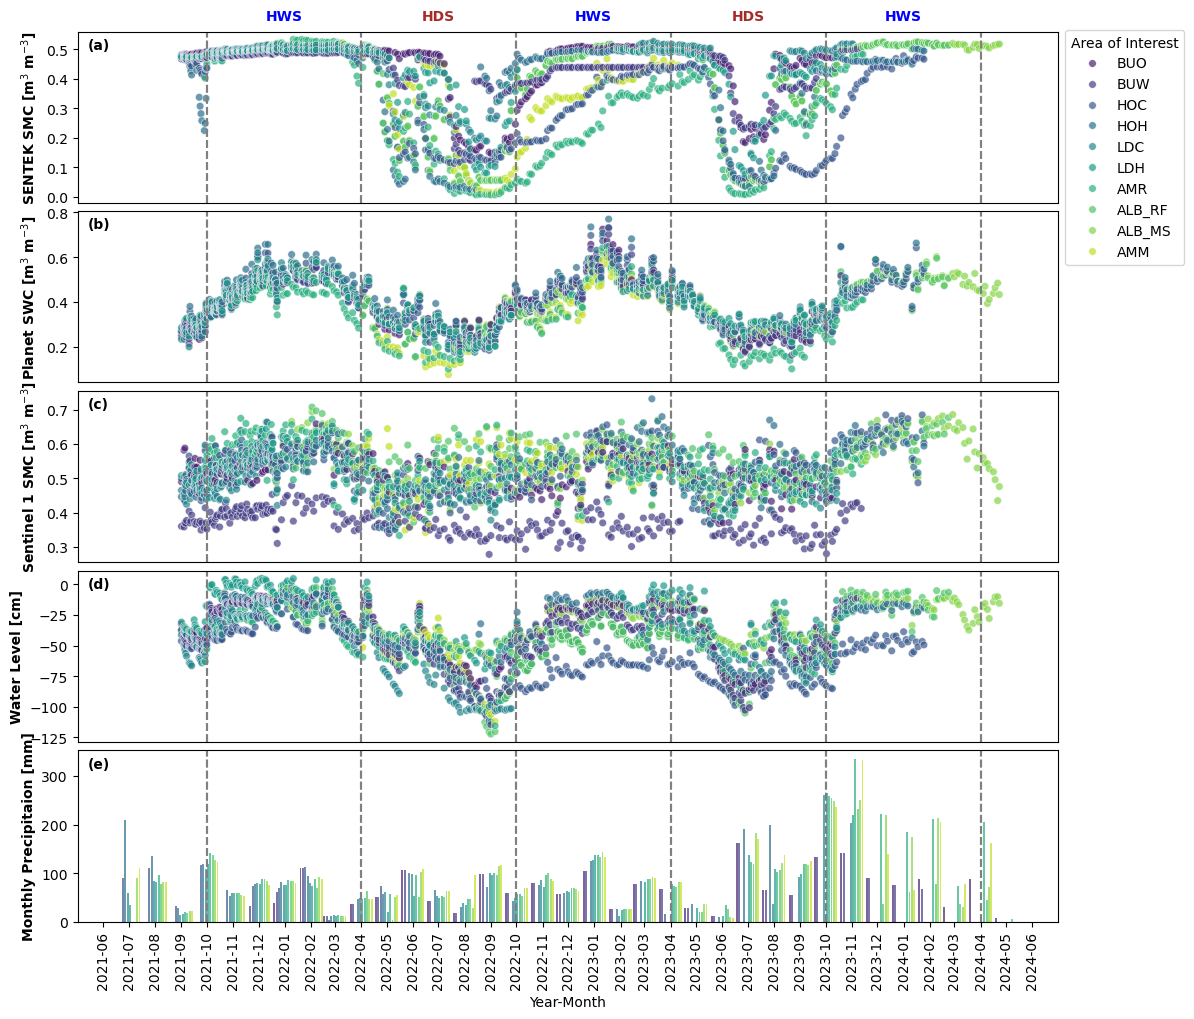

In [16]:
# Prepare TS_plot_df and drop rows with NaNs in relevant columns
TS_plot_df = complete_dataset[[
    "Date", "Site_ID", "SENTEK_SMC", "Planet_SMC", "Sentinel_1_SMC", "WLEV_f", "year_month"
]].copy()

TS_plot_df.dropna(subset=["SENTEK_SMC", "Planet_SMC", "Sentinel_1_SMC", "WLEV_f"], inplace=True)
# Prepare rainfall data
valid_sites = TS_plot_df["Site_ID"].unique()
rain_df = complete_dataset[["year_month", "Site_ID", "RAIN_f_monthly_sum"]].dropna().drop_duplicates(subset=["Site_ID", "year_month"])
rain_df = rain_df[rain_df["Site_ID"].isin(valid_sites)].copy()
rain_df["year_month_dt"] = pd.to_datetime(rain_df["year_month"].astype(str))

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(5, hspace=0.05)
axs = gs.subplots(sharex=True)
# SENTEK_SMC
sns.scatterplot(ax=axs[0], data=TS_plot_df, x="Date", y="SENTEK_SMC", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
axs[0].set_ylabel("SENTEK SMC [m$^{3}$ m$^{-3}$]", fontweight="bold")
axs[0].get_legend().remove()
axs[0].text(0.01, 0.9, "(a)", transform=axs[0].transAxes, fontsize=10, fontweight="bold")
# Planet_SMC
sns.scatterplot(ax=axs[1], data=TS_plot_df, x="Date", y="Planet_SMC", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
axs[1].set_ylabel("Planet SWC [m$^{3}$ m$^{-3}$]", fontweight="bold")
axs[1].legend(title="Area of Interest", bbox_to_anchor=(1.001, 2.1), loc='upper left')
axs[1].text(0.01, 0.9, "(b)", transform=axs[1].transAxes, fontsize=10, fontweight="bold")
# Sentinel_1_SMC
sns.scatterplot(ax=axs[2], data=TS_plot_df, x="Date", y="Sentinel_1_SMC", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
axs[2].set_ylabel("Sentinel 1 SMC [m$^{3}$ m$^{-3}$]", fontweight="bold")
axs[2].get_legend().remove()
axs[2].text(0.01, 0.9, "(c)", transform=axs[2].transAxes, fontsize=10, fontweight="bold")
# Water Level
sns.scatterplot(ax=axs[3], data=TS_plot_df, x="Date", y="WLEV_f", hue="Site_ID", palette="viridis", alpha=0.7, s=30)
axs[3].set_ylabel("Water Level [cm]", fontweight="bold")
axs[3].get_legend().remove()
axs[3].text(0.01, 0.9, "(d)", transform=axs[3].transAxes, fontsize=10, fontweight="bold")

sites = sorted(rain_df["Site_ID"].unique())
n_sites = len(sites)
bar_width = 25 / n_sites  # bar width in days
offsets = np.linspace(-bar_width * n_sites / 2, bar_width * n_sites / 2, n_sites)
colors = sns.color_palette("viridis", n_sites)
site_color_map = dict(zip(sites, colors))
for i, site in enumerate(sites):
    df_site = rain_df[rain_df["Site_ID"] == site]
    axs[4].bar(df_site["year_month_dt"] + pd.to_timedelta(offsets[i], unit="D"),
               df_site["RAIN_f_monthly_sum"],
               width=bar_width * 0.9,
               label=site,
               color=site_color_map[site],
               alpha=0.7)
    
season_start_dates = pd.date_range(start="2021-10-01", end="2024-04-01", freq="6MS")  
axs[4].set_ylabel("Monthly Precipitaion [mm]", fontweight="bold")
axs[4].set_xlabel("Year-Month")
axs[4].text(0.01, 0.9, "(e)", transform=axs[4].transAxes, fontsize=10, fontweight="bold")
legend = axs[4].get_legend()
if legend is not None:
    legend.remove()
axs[4].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[4].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axs[4].tick_params(axis='x', rotation=90)

for ax in axs[:-1]:
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
plt.subplots_adjust(left=0.1, right=0.8, top=0.97, bottom=0.08)
for date in season_start_dates:
    for ax in axs:
        ax.axvline(date, color="grey", linestyle="--", linewidth=1.5)
for date in season_start_dates:
    for ax in axs:
        ax.axvline(date, color="grey", linestyle="--", linewidth=1.5)

# Annotate HWS (Hydrological Wet Season) and HDS (Hydrological Dry Season)
season_labels = ["HWS", "HDS"] * (len(season_start_dates) // 2 + 1)
season_colors = ["blue", "brown"] * (len(season_start_dates) // 2 + 1)

for i, date in enumerate(season_start_dates[:-1]):
    mid_date = date + (season_start_dates[i+1] - date) / 2
    axs[0].annotate(season_labels[i],
                    xy=(mid_date, 1.05),
                    xycoords=('data', 'axes fraction'),
                    ha='center', va='bottom',
                    fontsize=10,
                    fontweight='bold',
                    color=season_colors[i])

#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/TS_5var.png"  
#ax.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()